# Classical Autoencoder

In this notebook we train a very simple classical Convolutional Autoencoder on a reduced version of the Quark Gluon dataset.

## imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from hep_VQAE import CAE as cae
import h5py
from sklearn.model_selection import train_test_split
from hep_VQAE import utils as ut
from matplotlib.colors import LogNorm
from matplotlib import cm


import tensorflow_addons as tfa

2024-06-20 17:28:07.267785: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-20 17:28:07.407106: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-06-20 17:28:07.407129: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2024-06-20 17:28:08.297247: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-

## Data

load the dataset

In [2]:
f = h5py.File("QG_hackathon_data_big","r")

In [3]:
x_train = f.get('X')
y_train = f.get('y')

In [4]:
x_train, x_val, y_train, y_val = train_test_split(x_train[:], y_train[:], test_size=0.2, shuffle=True)

like in the other notebooks we normalize the images by dividing every image by its largest pixel value. In addition we split the quarks (1) and gluons (0).

In [5]:
x_train_ones = x_train[y_train==1]
x_train_ones = x_train_ones.reshape(x_train_ones.shape + (1,))
x_train = x_train[y_train==0]
x_train = x_train.reshape(x_train.shape + (1,))

div1 = np.max(x_train, axis=(1,2)).reshape((x_train.shape[0],1,1,1))
div1[div1 == 0] = 1
x_train = x_train / div1
div2 = np.max(x_train_ones, axis=(1,2)).reshape((x_train_ones.shape[0],1,1,1))
div2[div2 == 0] = 1
x_train_ones = x_train_ones / div2

x_val_ones = x_val[y_val==1]
x_val_ones = x_val_ones.reshape(x_val_ones.shape + (1,))
x_val = x_val[y_val==0]
x_val = x_val.reshape(x_val.shape + (1,))

div1 = np.max(x_val, axis=(1,2)).reshape((x_val.shape[0],1,1,1))
div1[div1 == 0] = 1
x_val = x_val / div1
div2 = np.max(x_val_ones, axis=(1,2)).reshape((x_val_ones.shape[0],1,1,1))
div2[div2 == 0] = 1
x_val_ones = x_val_ones / div2

## Model

We build the Autoencoder model

In [6]:
from tensorflow.keras.models import Model
from tensorflow.keras import layers, losses
from keras.initializers import Constant
from keras.layers import PReLU

class Convolutional_Autoencoder(Model):
    """Convolutional Autoencoder model specifically for comparasion with Quantum models with a small number of parameters"""
    def __init__(self, latent_dim):
        """Create the model with given latenspace. Will have around 3000 parameters

        Args:
          latent_dim (int): number of latent neurons"""
        super(Convolutional_Autoencoder, self).__init__()

        self.encoder = tf.keras.Sequential([
          layers.Input(shape=(30, 30, 1)),
          layers.Conv2D(10, kernel_size=4, strides=1, padding='same'),
          PReLU(alpha_initializer=Constant(value=0.25)),
          layers.AveragePooling2D(pool_size=2),
          layers.Conv2D(5, kernel_size=4, strides=1, padding='same'),
          PReLU(alpha_initializer=Constant(value=0.25)),         
          layers.AveragePooling2D(pool_size=2),
          layers.Conv2D(5, kernel_size=2, strides=1, padding='same'),
          PReLU(alpha_initializer=Constant(value=0.25)),            
          layers.Flatten(),
          layers.Dense(25),
          PReLU(alpha_initializer=Constant(value=0.25)),            
          layers.Dense(latent_dim),
          PReLU(alpha_initializer=Constant(value=0.25))])

        self.decoder = tf.keras.Sequential([
          layers.Dense(81*1),
          PReLU(alpha_initializer=Constant(value=0.25)),
          layers.Reshape((9, 9, 1)),
          layers.Conv2D(5, kernel_size=2, strides=1, padding='same'),
          PReLU(alpha_initializer=Constant(value=0.25)),            
          layers.UpSampling2D(size=2),
          layers.Conv2D(5, kernel_size=4, strides=1, padding='same'),
          PReLU(alpha_initializer=Constant(value=0.25)),          
          layers.UpSampling2D(size=2),
          layers.Conv2D(10, kernel_size=4, strides=1, padding='valid'),
          PReLU(alpha_initializer=Constant(value=0.25)),            
          layers.Conv2D(1, kernel_size=4, strides=1, activation='sigmoid', padding='valid')])
            

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


In [7]:
model = Convolutional_Autoencoder(27)

2024-06-20 17:28:11.094892: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2024-06-20 17:28:11.094921: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2024-06-20 17:28:11.094951: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (tomskopfbahnhof): /proc/driver/nvidia/version does not exist
2024-06-20 17:28:11.095340: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
model.build(input_shape=(1,30,30,1))

This is what the model looks like:

In [9]:
model.summary()

Model: "convolutional__autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 27)                18354     
                                                                 
 sequential_1 (Sequential)   (1, 30, 30, 1)            16665     
                                                                 
Total params: 35,019
Trainable params: 35,019
Non-trainable params: 0
_________________________________________________________________


In [10]:
model.encoder.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 10)        170       
                                                                 
 p_re_lu (PReLU)             (None, 30, 30, 10)        9000      
                                                                 
 average_pooling2d (AverageP  (None, 15, 15, 10)       0         
 ooling2D)                                                       
                                                                 
 conv2d_1 (Conv2D)           (None, 15, 15, 5)         805       
                                                                 
 p_re_lu_1 (PReLU)           (None, 15, 15, 5)         1125      
                                                                 
 average_pooling2d_1 (Averag  (None, 7, 7, 5)          0         
 ePooling2D)                                            

In [11]:
model.decoder.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (1, 81)                   2268      
                                                                 
 p_re_lu_5 (PReLU)           (1, 81)                   81        
                                                                 
 reshape (Reshape)           (1, 9, 9, 1)              0         
                                                                 
 conv2d_3 (Conv2D)           (1, 9, 9, 5)              25        
                                                                 
 p_re_lu_6 (PReLU)           (1, 9, 9, 5)              405       
                                                                 
 up_sampling2d (UpSampling2D  (1, 18, 18, 5)           0         
 )                                                               
                                                      

## Training

I use adamw as optimizer

In [12]:
learning_rate = 0.0001
weight_decay = 0.00005
optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

In [13]:
model.compile(loss='binary_crossentropy', optimizer=optimizer)

We use early stopping on the validation loss. Training can take some time as we have to train for a lot of epochs.

In [14]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, min_delta=5e-6)
hist = model.fit(x_train_ones,x_train_ones,epochs=100,validation_data=(x_val_ones,x_val_ones),callbacks=[es], batch_size=128)

Epoch 1/100
356/356 [==============================] - 38s 102ms/step - loss: 0.2211 - val_loss: 0.0220
Epoch 2/100
356/356 [==============================] - 36s 102ms/step - loss: 0.0192 - val_loss: 0.0181
Epoch 3/100
356/356 [==============================] - 35s 98ms/step - loss: 0.0179 - val_loss: 0.0177
Epoch 4/100
356/356 [==============================] - 35s 98ms/step - loss: 0.0176 - val_loss: 0.0175
Epoch 5/100
356/356 [==============================] - 35s 98ms/step - loss: 0.0174 - val_loss: 0.0173
Epoch 6/100
356/356 [==============================] - 36s 101ms/step - loss: 0.0172 - val_loss: 0.0172
Epoch 7/100
356/356 [==============================] - 36s 100ms/step - loss: 0.0171 - val_loss: 0.0170
Epoch 8/100
356/356 [==============================] - 36s 101ms/step - loss: 0.0169 - val_loss: 0.0169
Epoch 9/100
356/356 [==============================] - 36s 102ms/step - loss: 0.0168 - val_loss: 0.0168
Epoch 10/100
356/356 [==============================] - 36s 100ms/s

Exception ignored in: <function WeakKeyDictionary.__init__.<locals>.remove at 0x7f34b3b85ee0>
Traceback (most recent call last):
  File "/home/tom/.conda/envs/tfq/lib/python3.9/weakref.py", line 370, in remove
KeyboardInterrupt: 

KeyboardInterrupt



# Evaluation

We can check the loss and auc history

In [ ]:
plt.plot(hist.history['loss'], label="training")
plt.plot(hist.history['val_loss'], label="validation")
plt.yscale('log')
plt.legend()

and evaluate the reconstruction abilities.
First on the data it was trained on

In [15]:
def eval_recon(x_test, x_recon, lognorm=False):
    """Evaluate the reconstruction capabilities of an autoencoder

    Args:
        x_true (array): True images
        x_recon (array): reconstructed image
        lognorm (bool): use logarithmic norm for example images

    Returns:
        evaluation plots
    """
    x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2],1)
    x_recon = x_recon.reshape(x_recon.shape[0], x_recon.shape[1], x_recon.shape[2],1)

    ssim = tf.reduce_mean(tf.image.ssim(x_test.astype('float64'), x_recon.astype('float64'), max_val=1.0)).numpy()
    MAE = tf.reduce_mean(tf.abs(x_test - x_recon)).numpy()
    normalized_MAE = MAE / tf.reduce_mean(tf.reduce_sum(x_test,axis=(1,2)).numpy().reshape((x_test.shape[0],1,1,1))).numpy()

    print(f'ssim: {ssim:.3}')
    print(f'MAE: {MAE:.3}')
    print(f'normalized MAE: {normalized_MAE:.3}')

    fig, axs = plt.subplots(2,3, figsize=(10, 5))

    if lognorm:
        norm = LogNorm()
    else:
        norm = None

    for i in range(3):
        rint = np.random.randint(len(x_test))
        axs[0,i].imshow(x_test[rint], cmap='binary', norm=norm)
        axs[0,i].title.set_text('true')

        fig.colorbar(cm.ScalarMappable(norm=norm, cmap='binary'), ax=axs[0,i])

        axs[1,i].imshow(x_recon[rint], cmap='binary', norm=norm)
        axs[1,i].title.set_text('reconstructed')

        fig.colorbar(cm.ScalarMappable(norm=norm, cmap='binary'), ax=axs[1,i])

    fig.tight_layout()


359/359 [==============================] - 3s 9ms/step
ssim: 0.873
MAE: 0.00379
normalized MAE: 0.00126


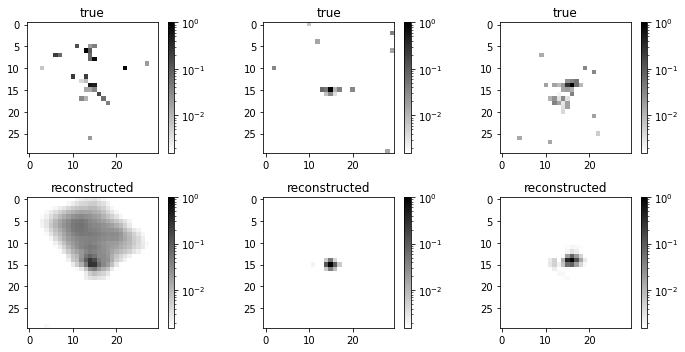

In [16]:
recon = model.predict(x_val_ones)

eval_recon(x_val_ones, recon, lognorm=True)

And now on the anomalous signal samples.

424/424 [==============================] - 4s 8ms/step
ssim: 0.833
MAE: 0.00477
normalized MAE: 0.00146


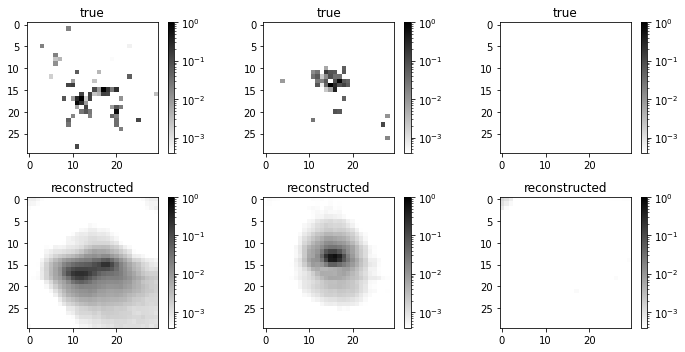

In [17]:
recon = model.predict(x_val)

eval_recon(x_val, recon, lognorm=True)

This is again the anomaly tagging performance

In [18]:
def eval_tagging(x_true_background, x_recon_background, x_true_signal, x_recon_signal):
    """Evaluate the anomaly tagging capabilities of an autoencoder

    Args:
        x_true_background (array): True images of background events
        x_recon_background (array): reconstructed images of background events
        x_true_signal (array): True images of signal events
        x_recon_signal (array): reconstructed images of signal events

    Returns:
        Plots for tagging evaluation
    """
    x_true_background = x_true_background.reshape(x_true_background.shape[0], x_true_background.shape[1], x_true_background.shape[2],1)
    x_recon_background = x_recon_background.reshape(x_recon_background.shape[0], x_recon_background.shape[1], x_recon_background.shape[2],1)
    x_true_signal = x_true_signal.reshape(x_true_signal.shape[0], x_true_signal.shape[1], x_true_signal.shape[2],1)
    x_recon_signal = x_recon_signal.reshape(x_recon_signal.shape[0], x_recon_signal.shape[1], x_recon_signal.shape[2],1)

    bce_background = tf.keras.losses.binary_crossentropy(x_true_background, x_recon_background, axis=(1,2,3)).numpy()
    bce_signal = tf.keras.losses.binary_crossentropy(x_true_signal, x_recon_signal, axis=(1,2,3)).numpy()

    fig, axs = plt.subplots(1,3, figsize=(11, 4))

    print(f'Median background: {np.median(bce_background):.3}')
    print(f'Median signal: {np.median(bce_signal):.3}')
    bins = np.histogram(np.hstack((bce_background, bce_signal)), bins=25)[1]
    axs[0].hist(bce_background, histtype='step', label="background",bins=bins)
    axs[0].hist(bce_signal, histtype='step', label="signal",bins=bins)
    axs[0].set_xlabel("loss")
    axs[0].legend()

    thresholds = np.linspace(0,max(np.max(bce_background),np.max(bce_signal)),1000)

    accs = []
    for i in thresholds:
        num_background_right = np.sum(bce_background < i)
        num_signal_right = np.sum(bce_signal > i)
        acc = (num_background_right + num_signal_right)/(len(x_recon_background) + len(x_recon_signal))
        accs.append(acc)

    print(f'Maximum accuracy: {np.max(accs):.3}')
    axs[1].plot(thresholds, accs)
    axs[1].set_xlabel("anomaly threshold")
    axs[1].set_ylabel("tagging accuracy")

    y_true = np.append(np.zeros(len(bce_background)), np.ones(len(bce_signal)))
    y_pred = np.append(bce_background, bce_signal)
    auc = roc_auc_score(y_true, y_pred)
    print(f'AUC: {auc:.4}')
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    tnr = 1 - fpr
    x = np.linspace(0,1,50)
    y_rnd = 1 - x
    axs[2].plot(tnr,tpr, label="anomaly tagging")
    axs[2].plot(x,y_rnd, label="random tagging", color='grey')
    axs[2].set_xlabel("fpr")
    axs[2].set_ylabel("tpr")
    axs[2].legend()

    fig.tight_layout()

359/359 [==============================] - 3s 9ms/step
Median background: 0.00912
Median signal: 0.012
Maximum accuracy: 0.561
AUC: 0.5551


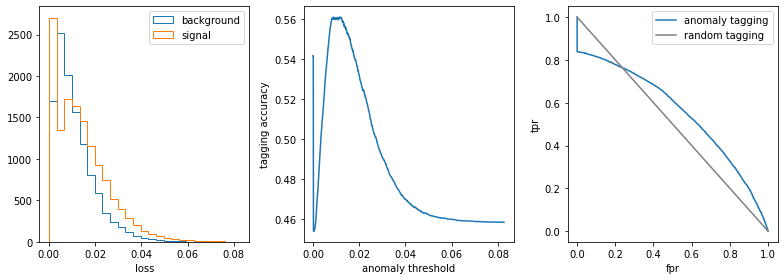

In [19]:
recon = model.predict(x_val)
recon_1 = model.predict(x_val_ones)

ut.eval_tagging(x_val_ones, recon_1, x_val, recon)